# Exercise project 3 – CNN for time series classification (PyTorch)

For this project, I used an existing PyTorch CNN implementation for time series classification. The code was based on a GitHub blog and served as a useful template for understanding how convolutional neural networks can work on 1D time series data.

https://lschmiddey.github.io/fastpages_/2021/04/30/Timeseries_Classification_with_ConvolutionalNeuralNet.html

### Step 0: Importing libraries and loading the dataset

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Step 1: Data analysis and visualisations

In [ ]:
folder_path = "/content/drive/MyDrive/deeplearning2024_VincenzinaSoos/ex_3"
os.chdir(folder_path)

In [ ]:
df_train = pd.read_csv('data/ItalyPowerDemand_TRAIN.txt', header=None, sep='\s+')
df_test = pd.read_csv('data/ItalyPowerDemand_TEST.txt', header=None, sep='\s+')

In [ ]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1.0,-0.710518,-1.183320,-1.372442,-1.593083,-1.467002,-1.372442,-1.088760,0.045967,0.928532,...,-0.647477,-0.269235,-0.206195,0.613330,1.369815,1.464375,1.054613,0.581810,0.172048,-0.269235
1,1.0,-0.993009,-1.426786,-1.579884,-1.605401,-1.630917,-1.375754,-1.018526,-0.355102,0.716583,...,0.486936,0.563485,0.614518,0.308322,0.257289,1.099327,1.048295,0.691066,-0.048906,-0.380618
2,2.0,1.319067,0.569774,0.195128,-0.085856,-0.179518,-0.273180,-0.085856,-1.397118,-1.116134,...,-0.554164,-0.741487,-0.741487,-0.741487,-1.116134,-0.460503,0.476113,2.349344,2.255682,1.600052
3,2.0,-0.812444,-1.157553,-1.416385,-1.531421,-1.502662,-1.416385,-1.646458,-0.467335,0.654269,...,0.740547,0.884342,0.884342,0.683028,0.625510,0.424197,-0.007190,-0.035949,0.107847,-0.266022
4,1.0,-0.972840,-1.390518,-1.536705,-1.620240,-1.620240,-1.453169,-0.993724,0.050469,0.635218,...,0.321960,0.489031,0.614334,1.303502,1.240850,1.073779,0.551682,0.426379,-0.179253,-0.638698


# PyTorch

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
len(df_train), len(df_test)

(67, 1029)

In [ ]:
x_train = df_train.iloc[:, 1:].values.reshape(-1, 1, 24)
x_test = df_test.iloc[:, 1:].values.reshape(-1, 1, 24)

In [ ]:
y_train = df_train.iloc[:, 0].values-1
y_test = df_test.iloc[:, 0].values-1

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((67, 1, 24), (1029, 1, 24), (67,), (1029,))

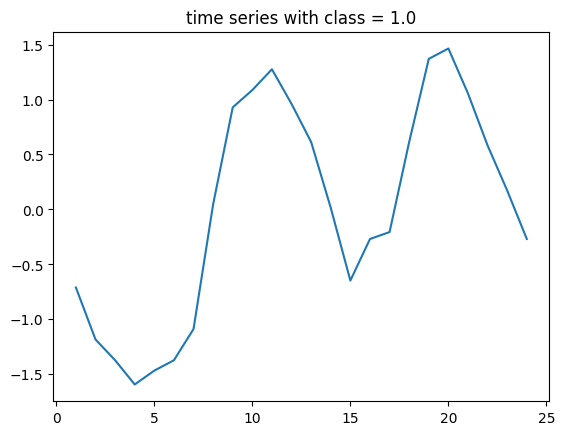

In [ ]:
df_train.iloc[0, 1:].plot.line(title=f'time series with class = {df_train.iloc[0, 0]}');

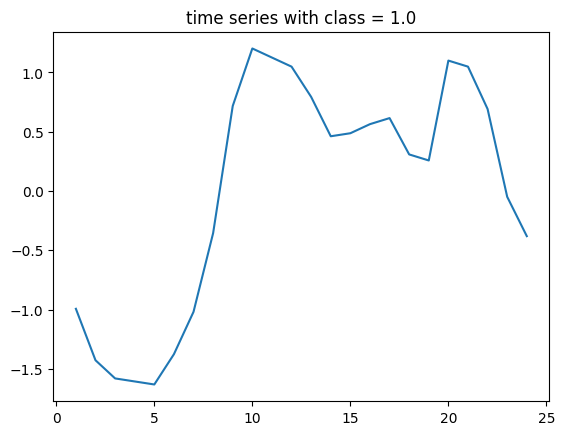

In [ ]:
df_train.iloc[1, 1:].plot.line(title=f'time series with class = {df_train.iloc[1, 0]}');

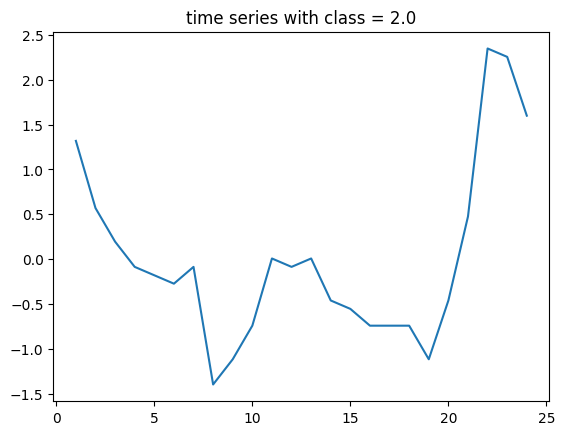

In [ ]:
df_train.iloc[2, 1:].plot.line(title=f'time series with class = {df_train.iloc[2, 0]}');

In [ ]:
def create_datasets(train, test, train_target, test_target, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets."""

    train, test, train_target, test_target = train, test, train_target, test_target
    assert len(train)==len(train_target)
    idx = np.arange(len(train))
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(train[trn_idx]).float(),
        torch.tensor(train_target[trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(train[val_idx]).float(),
        torch.tensor(train_target[val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(test).float(),
        torch.tensor(test_target).long())
    return trn_ds, val_ds, tst_ds

In [ ]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""

    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

datasets = create_datasets(x_train, x_test, y_train, y_test, seed=1234)
trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=256)

In [ ]:
class CostumConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [nn.Conv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [ ]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [ ]:
for epoch in range(1):
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
x_raw.shape

torch.Size([60, 1, 24])

In [ ]:
raw_ni=x_train.shape[1] # no of input features (here:1)
drop=0.3
m = CostumConv1d(raw_ni,  32, 23, 1, 0, drop=drop)
output_ = m(x_raw)
print(output_.shape)
# m = CostumConv1d(32,  64, 3, 2, 0, drop=drop)
# output_ = m(output_)
# print(output_.shape)
m = nn.MaxPool1d(2, stride=2)
output_ = m(output_)
print(output_.shape)

torch.Size([60, 32, 2])
torch.Size([60, 32, 1])


In [ ]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, no, drop=.5):
        super().__init__()

        self.raw = nn.Sequential(
            CostumConv1d(raw_ni,  128, 23, 1, 0, drop=drop),
            # CostumConv1d(    32,  64, 3, 2, 0, drop=drop),
            # CostumConv1d(    64,  256, 3, 1, 0, drop=drop),
            # CostumConv1d(    256,  256, 2, 1, 0, drop=drop),
            # CostumConv1d(    256, 256, 2, 1, 0, drop=drop),
            nn.MaxPool1d(2, stride=2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(128, 64), nn.ReLU(inplace=True),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.ReLU(inplace=True))

        self.out = nn.Sequential(
            nn.Linear(64, 64), nn.ReLU(inplace=True), nn.Linear(64, no))

    def forward(self, t_raw):
        raw_out = self.raw(t_raw)
        out = self.out(raw_out)
        return out

In [ ]:
raw_feat = x_train.shape[1]

lr = 0.001
n_epochs = 500
iterations_per_epoch = len(trn_dl)
num_classes = 2
best_acc = 0
patience, trials = 200, 0
base = 1
step = 2
loss_history = []
acc_history = []

model = Classifier(raw_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=lr)

In [ ]:
print('Start model training')
trn_sz = len(trn_dl.dataset)  # Total number of samples in the training dataset

for epoch in range(1, n_epochs + 1):

    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        x_raw, y_batch = [t.to(device) for t in batch]
        opt.zero_grad()
        out = model(x_raw)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()

    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)

    model.eval()
    correct, total = 0, 0
    for batch in val_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)

    if epoch % base == 0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
        base *= step

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

print('Done!')

Start model training
Epoch:   1. Loss: 0.0116. Acc.: 42.86%
Epoch 1 best model saved with accuracy: 42.86%
Epoch:   2. Loss: 0.0116. Acc.: 42.86%
Epoch:   4. Loss: 0.0115. Acc.: 42.86%
Epoch:   8. Loss: 0.0113. Acc.: 57.14%
Epoch 8 best model saved with accuracy: 57.14%
Epoch 15 best model saved with accuracy: 71.43%
Epoch:  16. Loss: 0.0110. Acc.: 71.43%
Epoch 19 best model saved with accuracy: 100.00%
Epoch:  32. Loss: 0.0071. Acc.: 100.00%
Epoch:  64. Loss: 0.0006. Acc.: 100.00%
Epoch: 128. Loss: 0.0009. Acc.: 100.00%
Early stopping on epoch 219
Done!


In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

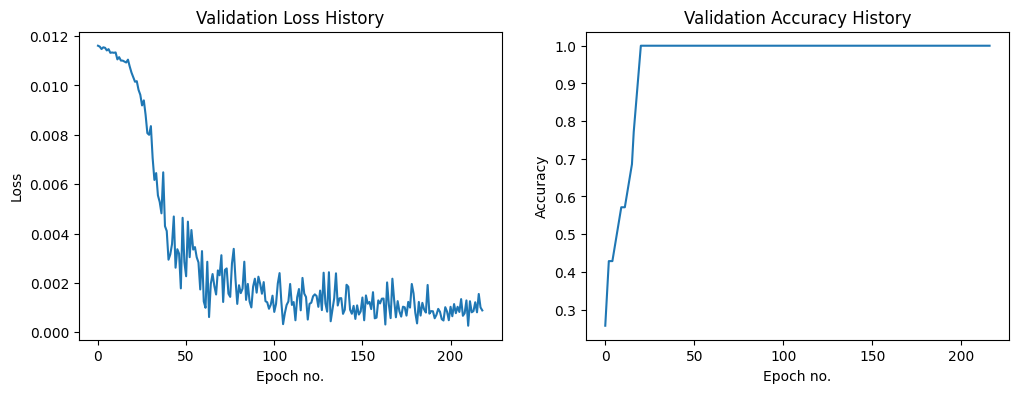

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [ ]:
preds_array = np.array([])
for batch in tst_dl:
        x_raw, y_batch = [t.to(device) for t in batch]
        out = model(x_raw)
        preds = F.log_softmax(out, dim=1).argmax(dim=1).numpy()
        preds_array = np.concatenate((preds_array, preds), axis=None)

The confusion matrix was fairly balanced, 499 correctly predicted class 1 samples and 501 for class 2, with just 29 total errors.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, preds_array)

array([[499,  14],
       [ 15, 501]])

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2']
print(classification_report(y_test, preds_array, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.97      0.97      0.97       513
     class 2       0.97      0.97      0.97       516

    accuracy                           0.97      1029
   macro avg       0.97      0.97      0.97      1029
weighted avg       0.97      0.97      0.97      1029



In [ ]:
wrongly_classified_idx = np.argwhere(y_test!=preds_array).reshape(-1)

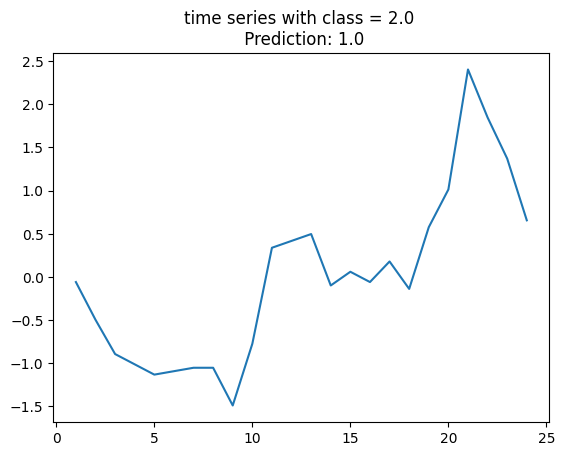

In [ ]:
df_test.iloc[wrongly_classified_idx[0], 1:].plot.line(title=f'time series with class = {df_test.iloc[wrongly_classified_idx[0], 0]} \n Prediction: {preds_array[wrongly_classified_idx[0]]+1}');

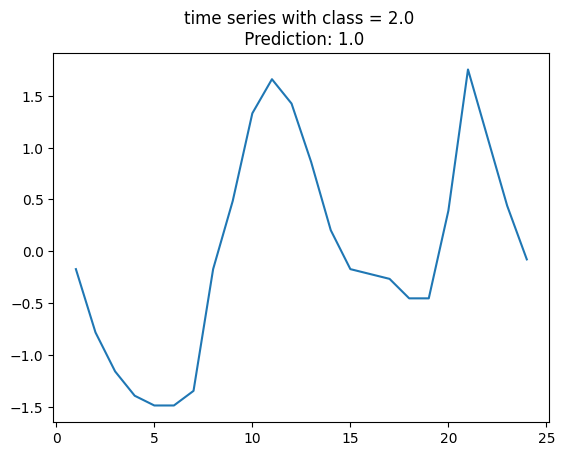

In [ ]:
df_test.iloc[wrongly_classified_idx[1], 1:].plot.line(title=f'time series with class = {df_test.iloc[wrongly_classified_idx[1], 0]} \n Prediction: {preds_array[wrongly_classified_idx[1]]+1}');

### Personal Analysis / Refelection

One of the first things I noticed was how different PyTorch feels compared to Keras. One of the first things I noticed was how different PyTorch feels compared to Keras.

The dataset only had 67 training samples and 1029 test samples. I was surprised the model performed so well despite such a tiny training set. By epoch 19, the validation accuracy reached 100%, and the final test accuracy was 97%.


Even though I didn’t build this model myself, reading and running the code helped me betetrunderstand the PyTorch training process more clearly.I also saw how CNNs can be applied to time series and compare manual training to more simple Keras workflows.